In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

def get_strict_comparison_plots(image_path, target_size=(2000, 1000)):
    # 1. 加载图片
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None: return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    # 2. 严格边缘提取 (保持原有逻辑)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((15, 15), np.uint8) 
    eroded_mask = cv2.erode(mask, kernel, iterations=2) 

    # 3. 找到有效区域的轮廓
    contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"⚠️ {image_path.name} 无法找到有效区域")
        return
    max_cnt = max(contours, key=cv2.contourArea)

    # --- 核心逻辑：带角度随机寻找 + 自动缩放 ---
    # --- 优化后的核心逻辑 ---
    curr_tw, curr_th = target_size
    best_crop = None
    best_box = None
    
    # 获取轮廓的包围盒，缩小随机范围，提高命中率
    rx, ry, rw, rh = cv2.boundingRect(max_cnt)

    while curr_tw >= 200 and best_crop is None:
        # 增加尝试次数到 500 次，给旋转寻找留出更多机会
        for i in range(500):
            # 在轮廓包围盒范围内随机中心点，而不是全图随机
            cx = random.randint(int((rx + rw)/2 - 100), int((rx + rw)/2 + 100))
            cy = random.randint(int((ry + rh)/2 - 100), int((ry + rh)/2 + 100))
            angle = random.uniform(0, 360)
            
            rect = ((cx, cy), (curr_tw, curr_th), angle)
            box = cv2.boxPoints(rect)
            
            # 快速检查：中心点必须在轮廓内，才进行后续复杂的角点检查
            if cv2.pointPolygonTest(max_cnt, (float(cx), float(cy)), False) < 0:
                continue

            # 检查四个角点
            is_inside = all([cv2.pointPolygonTest(max_cnt, (float(pt[0]), float(pt[1])), False) >= 0 for pt in box])
            
            if is_inside:
                M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
                # 注意：warpAffine 的尺寸要足够大，或者使用 borderMode
                rotated_img = cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LANCZOS4)
                best_crop = cv2.getRectSubPix(rotated_img, (curr_tw, curr_th), (cx, cy))
                best_box = box.astype(np.int32)
                break
        
        # 只有在 500 次尝试都失败后，才考虑缩小尺寸
        if best_crop is None:
            print(f"🔄 2000x1000 尝试失败，正在降低要求...")
            curr_tw -= 200
            curr_th -= 100

    if best_crop is None:
        print(f"❌ {image_path.name} 无法找到合适区域")
        return

    # 4. 可视化展示
    plt.figure(figsize=(20, 7))
    
    # 图1: 原图 + 红色曲线
    img_curve_viz = img_rgb.copy()
    cv2.drawContours(img_curve_viz, [max_cnt], -1, (255, 0, 0), 10)
    plt.subplot(1, 3, 1)
    plt.imshow(img_curve_viz)
    plt.title(f"Original & Boundary")
    plt.axis('off')
    
    # 图2: 动态旋转裁剪框示意
    img_sample_viz = img_curve_viz.copy()
    cv2.drawContours(img_sample_viz, [best_box], 0, (0, 0, 255), 30) # 画出旋转后的蓝色框
    plt.subplot(1, 3, 2)
    plt.imshow(img_sample_viz)
    plt.title(f"Random Rotated Crop Box\nSize: {curr_tw}x{curr_th}")
    plt.axis('off')
    
    # 图3: 最终裁剪结果展示 (已扶正)
    plt.subplot(1, 3, 3)
    plt.imshow(best_crop)
    plt.title(f"Final Crop Output (Straightened)\nPixels: {best_crop.shape[1]}W x {best_crop.shape[0]}H")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 执行
# data_dir = Path("你的路径")
# ...

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

def get_strict_comparison_plots(image_path, target_size=(2000, 1000)):
    # 1. 加载图片
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None: return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    # 2. 严格边缘提取
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((15, 15), np.uint8) 
    eroded_mask = cv2.erode(mask, kernel, iterations=2) 

    # 3. 找到有效区域的轮廓
    contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"⚠️ {image_path.name} 无法找到有效区域")
        return
    max_cnt = max(contours, key=cv2.contourArea)
    
    # --- 计算红色区域面积 (像素点个数) ---
    # 方法：使用 contourArea 得到轮廓包围的面积（像素为单位）
    red_zone_area = cv2.contourArea(max_cnt)

    # --- 核心逻辑：带角度随机寻找 + 自动缩放 ---
    curr_tw, curr_th = target_size
    best_crop = None
    best_box = None
    
    rx, ry, rw, rh = cv2.boundingRect(max_cnt)

    while curr_tw >= 200 and best_crop is None:
        for i in range(500):
            # 优化采样：在包围盒中心附近随机
            cx = random.randint(int((rx + rw/2) - 100), int((rx + rw/2) + 100))
            cy = random.randint(int((ry + rh/2) - 100), int((ry + rh/2) + 100))
            angle = random.uniform(0, 360)
            
            rect = ((cx, cy), (curr_tw, curr_th), angle)
            box = cv2.boxPoints(rect)
            
            if cv2.pointPolygonTest(max_cnt, (float(cx), float(cy)), False) < 0:
                continue

            is_inside = all([cv2.pointPolygonTest(max_cnt, (float(pt[0]), float(pt[1])), False) >= 0 for pt in box])
            
            if is_inside:
                M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
                rotated_img = cv2.warpAffine(img_rgb, M, (w, h), flags=cv2.INTER_LANCZOS4)
                best_crop = cv2.getRectSubPix(rotated_img, (curr_tw, curr_th), (cx, cy))
                best_box = box.astype(np.int32)
                break
        
        if best_crop is None:
            print(f"🔄 {curr_tw}x{curr_th} 尝试失败，正在降低要求...")
            curr_tw -= 200
            curr_th -= 100

    if best_crop is None:
        print(f"❌ {image_path.name} 无法找到合适区域")
        return

    # --- 计算最终裁剪结果面积 (像素点个数) ---
    crop_area = best_crop.shape[0] * best_crop.shape[1]

    # --- 打印结果 ---
    print("-" * 30)
    print(f"图片名称: {image_path.name}")
    print(f"红色边界内有效面积: {int(red_zone_area)} 像素")
    print(f"最终裁剪图像面积: {int(crop_area)} 像素 ({best_crop.shape[1]}x{best_crop.shape[0]})")
    print(f"面积占比: {(crop_area / red_zone_area * 100):.2f}%")
    print("-" * 30)

    # 4. 可视化展示
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 3, 1)
    img_curve_viz = img_rgb.copy()
    cv2.drawContours(img_curve_viz, [max_cnt], -1, (255, 0, 0), 10)
    plt.imshow(img_curve_viz)
    plt.title(f"Boundary Area: {int(red_zone_area)} px")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    img_sample_viz = img_curve_viz.copy()
    cv2.drawContours(img_sample_viz, [best_box], 0, (0, 0, 255), 30)
    plt.imshow(img_sample_viz)
    plt.title(f"Crop Box Position")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(best_crop)
    plt.title(f"Final Crop: {int(crop_area)} px")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

biomass_image_train_0039.jpg
🔄 2000x1000 尝试失败，正在降低要求...
------------------------------
图片名称: biomass_image_train_0039.jpg
红色边界内有效面积: 3855331 像素
最终裁剪图像面积: 1620000 像素 (1800x900)
面积占比: 42.02%
------------------------------


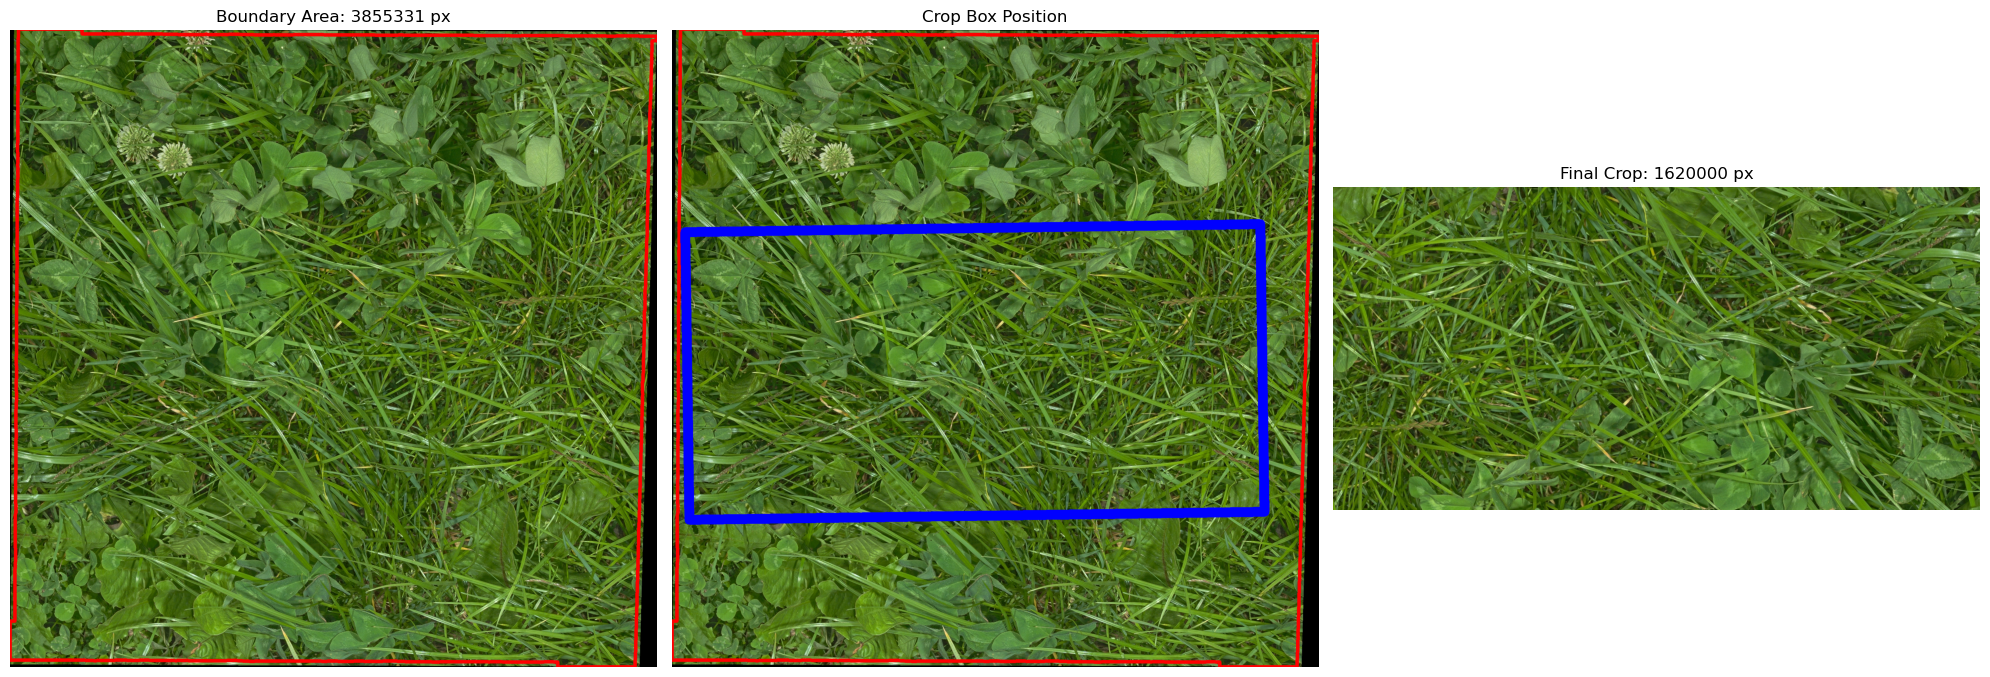

In [46]:
# 执行验证
data_dir = Path(r"D:\DATA_hao\Kaggle_\csiro-biomass\train_extra")
image_files = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))
if image_files:
    random_img = random.choice(image_files)
    # random_img = data_dir / "biomass_image_train_0172.jpg"
    print(random_img.name)
    get_strict_comparison_plots(random_img)

In [54]:
import pandas as pd

base_dir = r"D:\DATA_hao\Kaggle_\csiro-biomass"


# 设置文件路径
csv_path = Path(base_dir, "train_extra_data.csv")

df_extra = pd.read_csv(csv_path)
print(f"✅ 成功加载数据集，共 {len(df_extra)} 行记录。")

# 2. 查看数据结构（前5行）
print("\n数据预览:")
display(df_extra.head()) # 如果在 Jupyter Notebook 中使用
print(df_extra.columns)


✅ 成功加载数据集，共 261 行记录。

数据预览:


,image_file_name,acquisition_year,seasonal_harvest_no,label_type,fresh_grass,dry_grass,fresh_white_clover,dry_white_clover,fresh_red_clover,dry_red_clover,fresh_clover,dry_clover,fresh_weeds,dry_weeds,dry_total,dry_clover_fraction,dry_red_clover_fraction,dry_white_clover_fraction,dry_grass_fraction,dry_weeds_fraction
0,biomass_image_train_0000.jpg,2017,1,semi_advance,630.65,103.48,240.39,27.84,0.00,0.00,240.39,27.84,30.96,3.98,135.30,0.205765,0.000000,0.205765,0.764819,0.029416
1,biomass_image_train_0001.jpg,2017,1,basic,588.56,124.88,NaN,NaN,NaN,NaN,91.27,12.58,0.00,0.00,137.46,0.091518,0.000000,0.000000,0.908482,0.000000
2,biomass_image_train_0002.jpg,2017,1,semi_advance,437.74,83.06,3.91,0.64,0.00,0.00,3.91,0.64,27.38,3.44,87.14,0.007345,0.000000,0.007345,0.953179,0.039477
3,biomass_image_train_0003.jpg,2017,4,advance,72.39,9.92,221.12,26.86,8.98,1.51,230.10,28.37,80.44,9.76,48.05,0.590427,0.031426,0.559001,0.206452,0.203122
4,biomass_image_train_0004.jpg,2017,1,basic,111.21,23.14,NaN,NaN,NaN,NaN,417.18,61.11,0.00,0.00,84.25,0.725341,0.000000,0.000000,0.274659,0.000000


Index(['image_file_name', 'acquisition_year', 'seasonal_harvest_no',
       'label_type', 'fresh_grass', 'dry_grass', 'fresh_white_clover',
       'dry_white_clover', 'fresh_red_clover', 'dry_red_clover',
       'fresh_clover', 'dry_clover', 'fresh_weeds', 'dry_weeds', 'dry_total',
       'dry_clover_fraction', 'dry_red_clover_fraction',
       'dry_white_clover_fraction', 'dry_grass_fraction',
       'dry_weeds_fraction'],
      dtype='object')


In [59]:
import pandas as pd
from pathlib import Path

base_path = Path(r"train_extra2\train")
df_final = pd.DataFrame({
    'Dry_Clover_g': [base_path / name for name in df_extra['image_file_name']]
})






print(f"\n数据预览 (总行数: {len(df_final)}):")
display(df_final.head())


数据预览 (总行数: 261):


,Dry_Clover_g
0,train_extra2\train\biomass_image_train_0000.jpg
1,train_extra2\train\biomass_image_train_0001.jpg
2,train_extra2\train\biomass_image_train_0002.jpg
3,train_extra2\train\biomass_image_train_0003.jpg
4,train_extra2\train\biomass_image_train_0004.jpg


In [ ]:
# 假设 df_extra 是你的外部数据表格
df_extra['Dry_Clover_g'] = df_extra['dry_white_clover'].fillna(0) + df_extra['dry_red_clover'].fillna(0)
df_extra['Dry_Green_g'] = df_extra['dry_grass'].fillna(0) + df_extra['dry_weeds'].fillna(0)
df_extra['Dry_Dead_g'] = 0  # 如果没有枯草数据，暂设为0或通过 total 减去其他项
df_extra['GDM_g'] = df_extra['Dry_Green_g'] + df_extra['Dry_Clover_g']
df_extra['Dry_Total_g'] = df_extra['dry_total']